# Spectroscopic overlaps

__Date:__ February 21, 2024

Testing spectroscopic overlaps $\langle \Psi^{A-1}_{\alpha} \lvert a_{\mathbf{q}} \rvert \Psi^A_0 \rangle$ using SRG transformations.

_Last update:_ February 26, 2024

In [1]:
# Python imports
from matplotlib.offsetbox import AnchoredText
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np

In [2]:
# Imports from scripts
from scripts.figures import set_rc_parameters
from scripts.momentum_distributions import load_momentum_distribution
from spectroscopic_overlaps_vegas import SingleParticleState, load_overlap

### Set-up

In [3]:
# Run this cell to turn on customized matplotlib graphics
set_rc_parameters()

## Coordinate-space overlaps

VMC SF = 1.62011


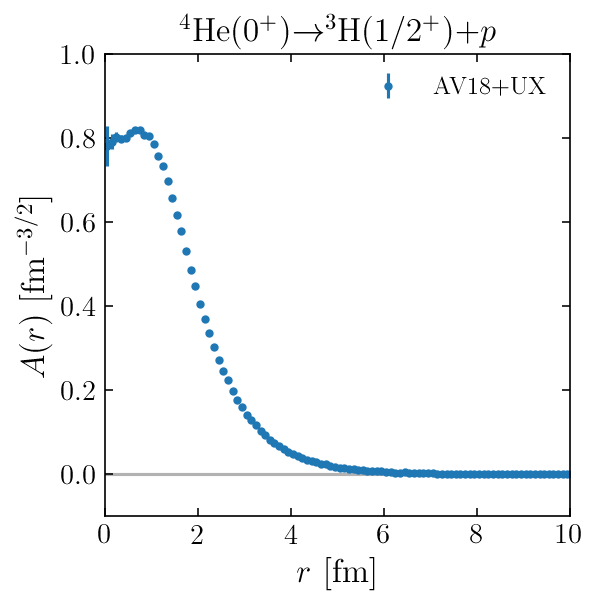

In [4]:
data = np.loadtxt('../data/vmc/spectroscopic_amplitudes/h3p.table.txt')

x_limits = (0, 10)
y_limits = (-0.1, 1)

r_array = data[:, 0]
vmc_overlap_array = data[:, 1]
vmc_errors = data[:, 2]

# Print SF
norm = np.trapz(r_array ** 2 * np.abs(vmc_overlap_array) ** 2, x=r_array)
print(f"VMC SF = {norm:.5f}")

plt.close('all')
f, ax = plt.subplots(figsize=(4, 4))
ax.errorbar(r_array, vmc_overlap_array, yerr=vmc_errors, label='AV18+UX', ls='',
            marker='.')
ax.axhline(y=0, alpha=0.3, color='black')
ax.set_xlim(x_limits)
ax.set_ylim(y_limits)
ax.set_xlabel(r"$r$ [fm]", fontsize=16)
ax.set_ylabel(r"$A(r)$ [fm" + r'$^{-3/2}$' + ']', fontsize=16)
ax.legend(loc='upper right', fontsize=12, frameon=False)
label = r"$^{4}$He($0^+$)" + r"$\rightarrow$" + r"$^3$H($1/2^+$)" + r"$+p$"
ax.set_title(label, fontsize=16)
plt.show();

## Momentum-space overlaps

In [5]:
def load_vmc(nucleus_name, print_normalization=True):
    """
    Loads the VMC spectroscopic overlap.
    
    Notes
    -----
    The spectroscopic overlap has the following normalization:
    
        S_\alpha = 1/(2\pi)^3 \int_0^\infty dq q^2 |A(q)|^2,
        
    where A(q) [fm^3/2] is the overlap.
    
    """
    
    vmc_directory = "../data/vmc/spectroscopic_amplitudes/"
    if nucleus_name == 'He4':
        file_name = "h3p_ms.txt"
        index = 0
    else:
        file_name = "b11p3_ms.txt"
        index = 3
    
    f = open(vmc_directory + file_name, 'r')
    data_list = []
    
    for line in f:
        
        unit = line.strip().split()
        if unit[0] == "#":
            pass
        else:
            data_list.append([
                float(unit[0]), float(unit[1+index]),
                float(unit[2+index].strip('(').strip(')'))
            ])
            
    # Convert to NumPy array
    data = np.array(data_list)
    q_array = data[:, 0]
    overlap_array = data[:, 1]
    errors = data[:, 2]
    
    if print_normalization:
        norm = (
            np.trapz(q_array ** 2 * np.abs(overlap_array) ** 2, x=q_array)
            / (2*np.pi) ** 3
        )
        print(f"VMC SF = {norm:.5f}")
    
    return q_array, overlap_array, errors

In [6]:
def load_srg(nucleus_name, alpha, print_normalization=True):
    
    (q_array, q_weights, overlap_array, I_array, delta_U_array,
     delta_U_errors) = load_overlap(nucleus_name, alpha, 6, 1.5)

    factor = np.sqrt((2*np.pi) ** 3 * (2*alpha.j+1) * 4 * np.pi)
    
    q_array = np.real(q_array)
    q_weights = np.real(q_weights)
    overlap_array *= factor
    I_array *= factor
    delta_U_array *= factor
    delta_U_errors = factor * np.real(delta_U_errors)
    
    if print_normalization:
        norm = (
            np.sum(q_weights * q_array ** 2 * np.abs(overlap_array) ** 2)
            / (2*np.pi) ** 3
        )
        print(f"SRG SF = {norm:.5f}")
    
    return q_array, overlap_array, I_array, delta_U_array, delta_U_errors

$^{4}$He($0^+$) $\rightarrow$ $^3$H($1/2^+$) $+p$</br>
VMC uses AV18 and UX</br>
SRG uses AV18 at $\lambda=1.5$ fm$^{-1}$

In [7]:
n, l, j, m_j, m_t = 1, 0, 1/2, 1/2, 1/2
alpha = SingleParticleState(n, l, j, m_j, m_t)

VMC SF = 1.62215
TESTING = 78.95683520871486
SRG SF = 1.84050


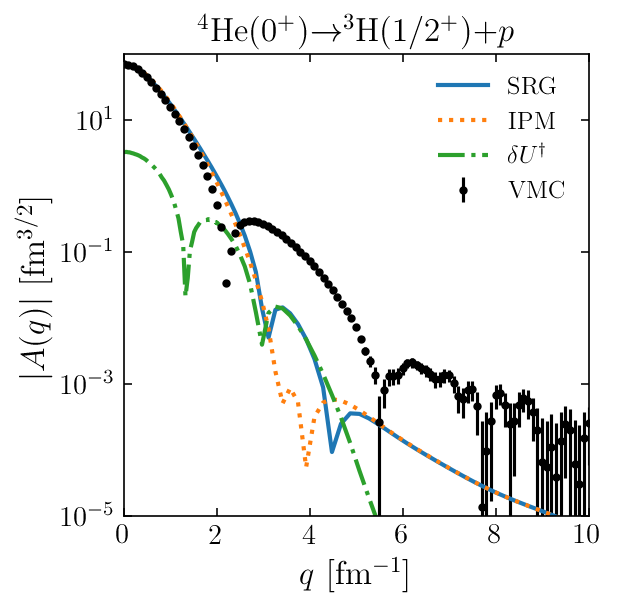

In [8]:
# VMC with AV18+UX
q_vmc, vmc_overlap, vmc_errors = load_vmc('He4')

# SRG with AV18 at \lambda=1.5 fm^-1
q_srg, srg_overlap, srg_ipm, srg_delta, srg_errors = load_srg('He4', alpha)

x_limits = (0, 10)
y_limits = (1e-5, 1e2)

plt.close('all')
f, ax = plt.subplots(figsize=(4, 4))
ax.set_yscale('log')
ax.errorbar(q_vmc, np.abs(vmc_overlap), yerr=vmc_errors, label='VMC', ls='',
            marker='.', color='black')
ax.plot(q_srg, np.abs(srg_overlap), label='SRG', lw=2.0)
ax.plot(q_srg, np.abs(srg_ipm), label='IPM', ls='dotted', lw=2.0)
ax.plot(q_srg, np.abs(srg_delta), label=r'$\delta U^\dagger$', ls='dashdot',
        lw=2.0)
ax.set_xlim(x_limits)
ax.set_ylim(y_limits)
ax.set_xlabel(r"$q$ [fm" + r'$^{-1}$' + ']', fontsize=16)
ax.set_ylabel(r"$|A(q)|$ [fm" + r'$^{3/2}$' + ']', fontsize=16)
ax.legend(loc='upper right', fontsize=12, frameon=False)
label = r"$^{4}$He($0^+$)" + r"$\rightarrow$" + r"$^3$H($1/2^+$)" + r"$+p$"
ax.set_title(label, fontsize=16)
plt.show();

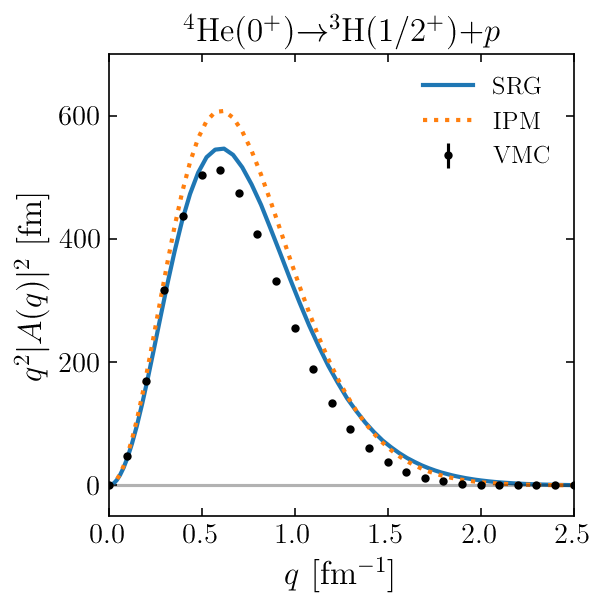

In [9]:
x_limits = (0, 2.5)
y_limits = (-50, 700)

plt.close('all')
f, ax = plt.subplots(figsize=(4, 4))
ax.set_yscale('linear')
ax.errorbar(
    q_vmc, vmc_overlap ** 2 * q_vmc ** 2, yerr=vmc_errors * q_vmc ** 2,
    label='VMC', ls='', marker='.', color='black'
)
ax.plot(q_srg, np.abs(srg_overlap) ** 2 * q_srg ** 2, label='SRG', lw=2.0)
ax.plot(q_srg, np.abs(srg_ipm) ** 2 * q_srg ** 2, label='IPM', ls='dotted',
        lw=2.0)
ax.axhline(y=0, alpha=0.3, color='black')
ax.set_xlim(x_limits)
ax.set_ylim(y_limits)
ax.set_xlabel(r"$q$ [fm" + r'$^{-1}$' + ']', fontsize=16)
ax.set_ylabel(r"$q^2 |A(q)|^2$ [fm]", fontsize=16)
ax.legend(loc='upper right', fontsize=12, frameon=False)
label = r"$^{4}$He($0^+$)" + r"$\rightarrow$" + r"$^3$H($1/2^+$)" + r"$+p$"
ax.set_title(label, fontsize=16)
plt.show();

## Compare to momentum distribution

$$
n(q) = \langle \Psi^{A}_{0}(\lambda) \lvert U(\lambda) a^\dagger_{\mathbf{q}} a_{\mathbf{q}} U^\dagger(\lambda) \rvert \Psi^{A}_{0}(\lambda) \rangle \\
= \sum_{\alpha}
    \langle \Psi^{A}_{0}(\lambda) \lvert U(\lambda) a^\dagger_{\mathbf{q}} U^\dagger(\lambda) \rvert \Psi^{A-1}_{\alpha}(\lambda) \rangle
    \langle \Psi^{A-1}_{\alpha}(\lambda) \lvert U(\lambda) a_{\mathbf{q}} U^\dagger(\lambda) \rvert \Psi^{A}_{0}(\lambda) \rangle \\
= \sum_{\alpha} \lvert \langle \Psi^{A-1}_{\alpha}(\lambda) \lvert U(\lambda) a_{\mathbf{q}} U^\dagger(\lambda) \rvert \Psi^{A}_{0}(\lambda) \rangle \rvert^2 
$$

Normalization of momentum distribution = 1.99863


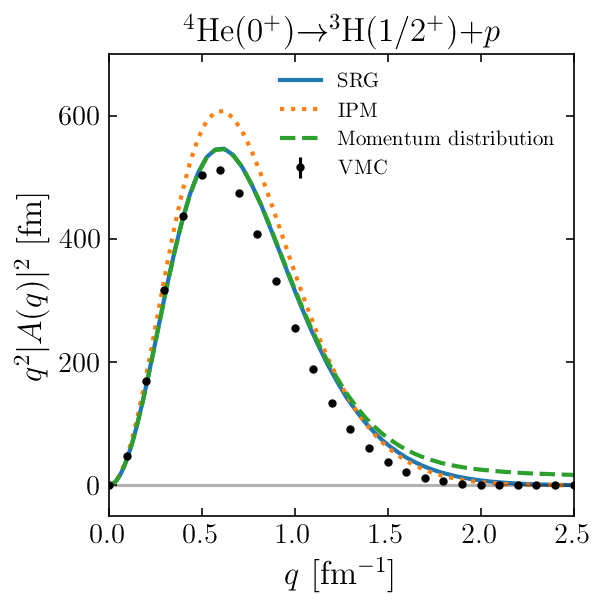

In [10]:
x_limits = (0, 2.5)
y_limits = (-50, 700)

(q_array, q_weights, n_array, n_errors, I_array, delta_U_array, delta_U_errors,
 delta_U2_array, delta_U2_errors) = load_momentum_distribution('He4', 'proton',
                                                               6, 1.5)
factor = (2*np.pi) ** 3 * 4*np.pi
n_array *= factor
norm = np.sum(q_weights * q_array ** 2 * n_array) / (2*np.pi) ** 3
print(f'Normalization of momentum distribution = {norm:.5f}')

plt.close('all')
f, ax = plt.subplots(figsize=(4, 4))
ax.set_yscale('linear')
ax.errorbar(
    q_vmc, vmc_overlap ** 2 * q_vmc ** 2, yerr=vmc_errors * q_vmc ** 2,
    label='VMC', ls='', marker='.', color='black'
)
ax.plot(q_srg, np.abs(srg_overlap) ** 2 * q_srg ** 2, label='SRG', lw=2.0)
ax.plot(q_srg, np.abs(srg_ipm) ** 2 * q_srg ** 2, label='IPM', ls='dotted',
        lw=2.0)
ax.plot(q_array, n_array * q_array ** 2, label='Momentum distribution',
        ls='dashed', lw=2.0)
ax.axhline(y=0, alpha=0.3, color='black')
ax.set_xlim(x_limits)
ax.set_ylim(y_limits)
ax.set_xlabel(r"$q$ [fm" + r'$^{-1}$' + ']', fontsize=16)
ax.set_ylabel(r"$q^2 |A(q)|^2$ [fm]", fontsize=16)
ax.legend(loc='upper right', fontsize=10, frameon=False)
label = r"$^{4}$He($0^+$)" + r"$\rightarrow$" + r"$^3$H($1/2^+$)" + r"$+p$"
ax.set_title(label, fontsize=16)
plt.show();

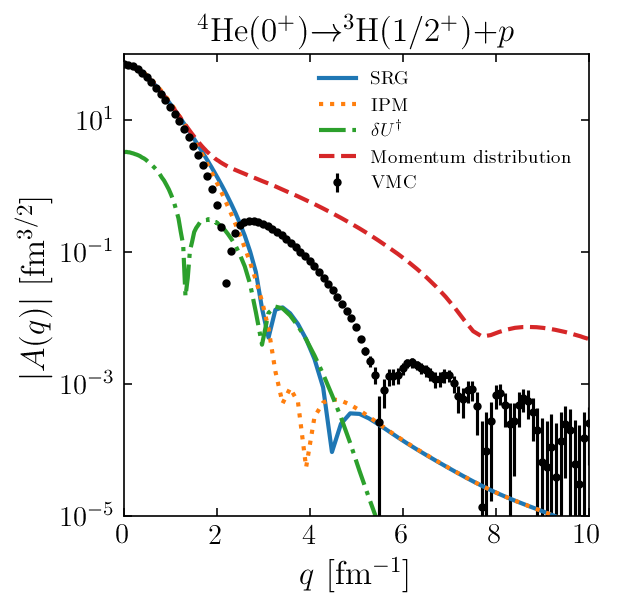

In [11]:
x_limits = (0, 10)
y_limits = (1e-5, 1e2)

plt.close('all')
f, ax = plt.subplots(figsize=(4, 4))
ax.set_yscale('log')
ax.errorbar(q_vmc, np.abs(vmc_overlap), yerr=vmc_errors, label='VMC', ls='',
            marker='.', color='black')
ax.plot(q_srg, np.abs(srg_overlap), label='SRG', lw=2.0)
ax.plot(q_srg, np.abs(srg_ipm), label='IPM', ls='dotted', lw=2.0)
ax.plot(q_srg, np.abs(srg_delta), label=r'$\delta U^\dagger$', ls='dashdot',
        lw=2.0)
ax.plot(q_array, np.sqrt(n_array), label='Momentum distribution', ls='dashed',
        lw=2.0)
ax.set_xlim(x_limits)
ax.set_ylim(y_limits)
ax.set_xlabel(r"$q$ [fm" + r'$^{-1}$' + ']', fontsize=16)
ax.set_ylabel(r"$|A(q)|$ [fm" + r'$^{3/2}$' + ']', fontsize=16)
ax.legend(loc='upper right', fontsize=9, frameon=False)
label = r"$^{4}$He($0^+$)" + r"$\rightarrow$" + r"$^3$H($1/2^+$)" + r"$+p$"
ax.set_title(label, fontsize=16)
plt.show();

$^{12}$C($0^+$) $\rightarrow$ $^{11}$B($3/2^-$) $+p$</br>
VMC uses AV18 and UX</br>
SRG uses AV18 at $\lambda=1.5$ fm$^{-1}$

In [12]:
n, l, j, m_j, m_t = 1, 1, 3/2, 1/2, 1/2
alpha = SingleParticleState(n, l, j, m_j, m_t)

VMC SF = 2.36344
TESTING = 111.66182719422206
SRG SF = 7.36521
Normalization of momentum distribution = 5.99927


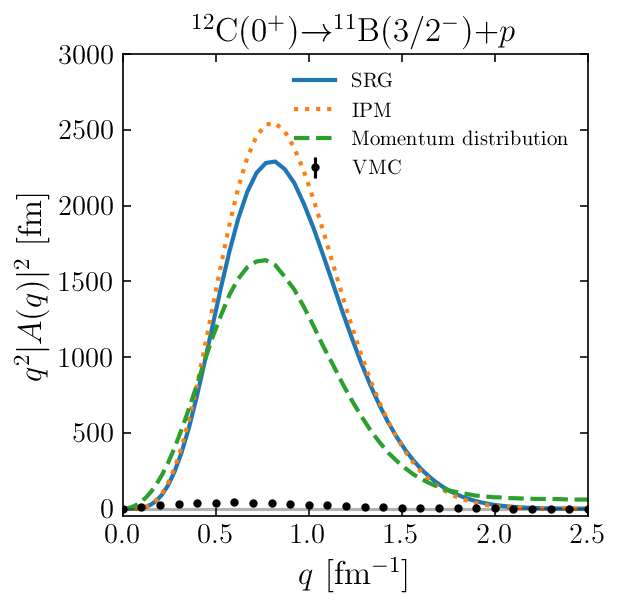

In [13]:
x_limits = (0, 2.5)
y_limits = (-50, 3000)

# VMC overlap
q_vmc, vmc_overlap, vmc_errors = load_vmc('C12')

# SRG with AV18 at \lambda=1.5 fm^-1
q_srg, srg_overlap, srg_ipm, srg_delta, srg_errors = load_srg('C12', alpha)

(q_array, q_weights, n_array, n_errors, I_array, delta_U_array, delta_U_errors,
 delta_U2_array, delta_U2_errors) = load_momentum_distribution('C12', 'proton',
                                                               6, 1.5)
factor = (2*np.pi) ** 3 * 4*np.pi
n_array *= factor
norm = np.sum(q_weights * q_array ** 2 * n_array) / (2*np.pi) ** 3
print(f'Normalization of momentum distribution = {norm:.5f}')

plt.close('all')
f, ax = plt.subplots(figsize=(4, 4))
ax.set_yscale('linear')
ax.errorbar(q_vmc, np.abs(vmc_overlap), yerr=vmc_errors, label='VMC', ls='',
            marker='.', color='black')
ax.plot(q_srg, np.abs(srg_overlap) ** 2 * q_srg ** 2, label='SRG', lw=2.0)
ax.plot(q_srg, np.abs(srg_ipm) ** 2 * q_srg ** 2, label='IPM', ls='dotted',
        lw=2.0)
ax.plot(q_array, n_array * q_array ** 2, label='Momentum distribution',
        ls='dashed', lw=2.0)
ax.axhline(y=0, alpha=0.3, color='black')
ax.set_xlim(x_limits)
ax.set_ylim(y_limits)
ax.set_xlabel(r"$q$ [fm" + r'$^{-1}$' + ']', fontsize=16)
ax.set_ylabel(r"$q^2 |A(q)|^2$ [fm]", fontsize=16)
ax.legend(loc='upper right', fontsize=10, frameon=False)
label = r"$^{12}$C($0^+$)" + r"$\rightarrow$" + r"$^{11}$B($3/2^-$)" + r"$+p$"
ax.set_title(label, fontsize=16)
plt.show();

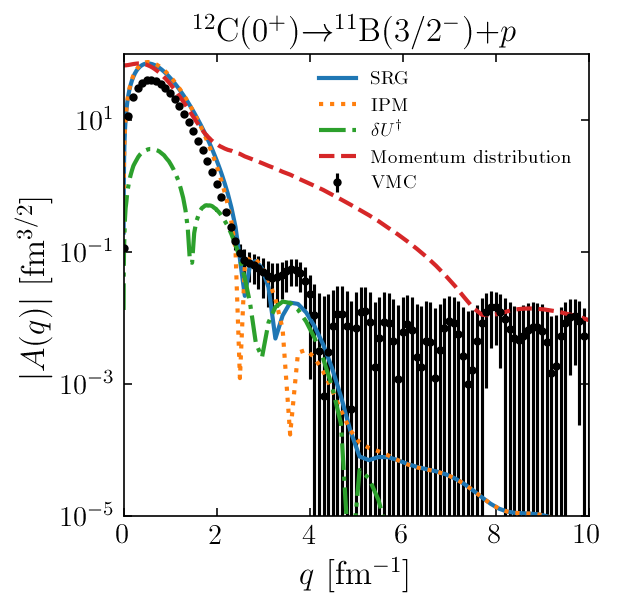

In [14]:
x_limits = (0, 10)
y_limits = (1e-5, 1e2)

plt.close('all')
f, ax = plt.subplots(figsize=(4, 4))
ax.set_yscale('log')
ax.errorbar(q_vmc, np.abs(vmc_overlap), yerr=vmc_errors, label='VMC', ls='',
            marker='.', color='black')
ax.plot(q_srg, np.abs(srg_overlap), label='SRG', lw=2.0)
ax.plot(q_srg, np.abs(srg_ipm), label='IPM', ls='dotted', lw=2.0)
ax.plot(q_srg, np.abs(srg_delta), label=r'$\delta U^\dagger$', ls='dashdot',
        lw=2.0)
ax.plot(q_array, np.sqrt(n_array), label='Momentum distribution', ls='dashed',
        lw=2.0)
ax.set_xlim(x_limits)
ax.set_ylim(y_limits)
ax.set_xlabel(r"$q$ [fm" + r'$^{-1}$' + ']', fontsize=16)
ax.set_ylabel(r"$|A(q)|$ [fm" + r'$^{3/2}$' + ']', fontsize=16)
ax.legend(loc='upper right', fontsize=9, frameon=False)
label = r"$^{12}$C($0^+$)" + r"$\rightarrow$" + r"$^{11}$B($3/2^-$)" + r"$+p$"
ax.set_title(label, fontsize=16)
plt.show();